# Leaky modes of antiguide

Here we explore the leaky modes of the anti-guide (or hole waveguide).  This device only has leaky modes.  We also explore how we actually form leaky modes from residues around poles of radiation modes.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact
from fiberamp.fiber.microstruct.bragg import plotlogf, plotlogf_real
from scipy.optimize import newton
from IPython.display import Video

plt.style.use('dark_background')
%matplotlib widget

In [3]:
A = SlabExact(scale=1e-6, Ts=[4, 2, 4],
              ns=[1.44, 1, 1.44], xrefs=[400, 200, 400],
              symmetric=True, wl=1e-6)

In [ ]:
# Set variables for plotting
field_type = 'TE'
mode_type = 'leaky'
k_low = A.K_low

# Form leaky modes from beta plane eigenvalues

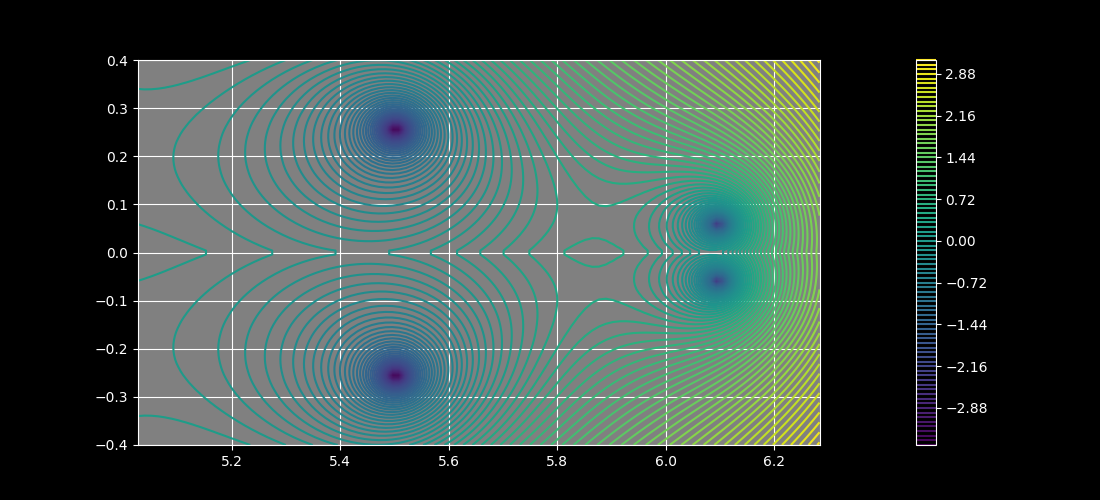

In [6]:
plotlogf(A.determinant, .8*k_low, 1.0001*k_low, -.4, .4, field_type, mode_type,
         iref=100, rref=100,levels=100, figsize=(11,5))

Let's grab the eigenvalue with the lowest loss:

In [17]:
beta1 = newton(A.determinant, np.array([.99*k_low]), args=('TE', mode_type))
print(beta1, abs(A.determinant(beta1, 'TE', mode_type)))
plt.plot(beta1.real, beta1.imag, 'ro');

[6.09736487+0.05891831j] [6.05444213e-13]


Note that our ansatz calls for beta to have positive imaginary part

### Normal procedure for consructing leaky modes.

Since we know they are zeros of the eigenequation, and that means we only have 1 outer component, we just set things up with the null vector associated with zero of determinant

In [18]:
Fs1 = A.fields(beta1, field_type='TE', mode_type=mode_type, c0=1)


The coefficients are:

In [19]:
A.coefficients(beta1, field_type='TE', mode_type=mode_type).T

array([[ 1.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 1.16147428-1.88135852e+00j,  1.16147428-1.88135852e+00j],
       [-0.        +1.00000000e-12j,  1.        +1.00000000e-12j]])

In [20]:
A.transmission_matrix(beta1)[0] 

array([[-2.34154383e-13+5.58331819e-13j, -1.00000000e+00-5.51836354e-13j],
       [ 1.00000000e+00+5.40789635e-13j, -1.33806441e+00+1.47624142e+00j]])

Because of the form of the transmission matrix, we have single component left and right waves, ie 1,0 maps to 0,1: 

In [21]:
A.transmission_matrix(beta1)[0] @ np.array([1,0])

array([-2.34154383e-13+5.58331819e-13j,  1.00000000e+00+5.40789635e-13j])

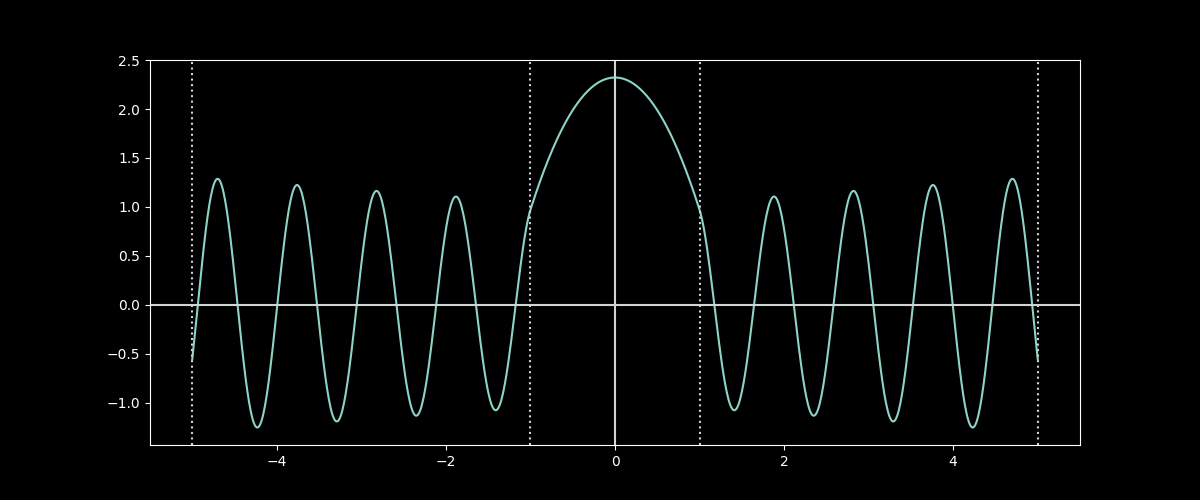

In [22]:
A.plot_field_1d(Fs1);


This means the we have single motion waves in the transverse direction in both high index regions.  The animation below shows they are both outward going!  OMG that is what it means!

In [15]:
# A.animate_field_1d(Fs1, 'leaky', linewidth=2.5, secs=3, fps=32)

In [16]:
Video('leaky.mp4', html_attributes="controls loop")



# Setting leaky mode with radiation mode normalization

In theory this normalization is the one we should use for the leaky mode representation (actually we need the residual at this point, but this is a good first step to investigate).

In [23]:
Fs2 = A.fields(beta1, field_type='TE', mode_type='radiation', paper_method=True, sign='1')


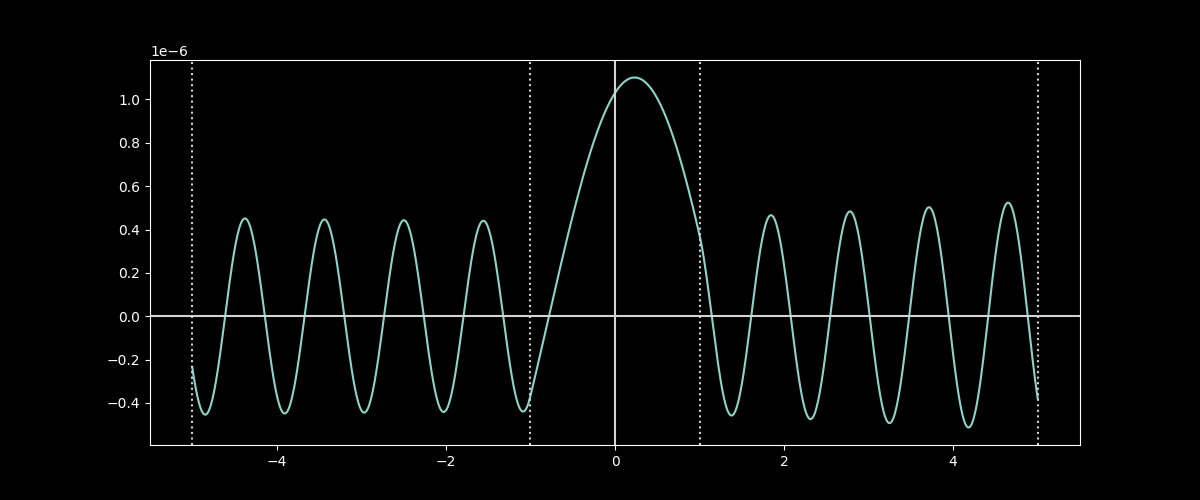

In [24]:
A.plot_field_1d(lambda x: -Fs2(x));


Hmm, paper method of normalization doesn't preserve even/odd for complex Z.  Also the overall function is pretty tiny. I later find out that in fact there is no radiation mode here, it would be zero.  We can see this in the coefficients better:

In [25]:
A.coefficients(beta1, field_type='TE', mode_type='radiation', paper_method=True, sign='1').T**2

array([[-1.86335136e-14+4.44307747e-14j, -1.86335136e-14-4.44307747e-14j],
       [ 3.86739640e-13-1.35551606e-13j,  9.61181178e-14+2.00647617e-13j],
       [ 3.52055340e-14+1.54154279e-13j, -1.86335136e-14+4.44307747e-14j]])

We square the above because the square root that happens when forming the coefficient takes something that would be close to machine zero to something that looks not too small.  This is a numeric artifact however, and the coefficients should be zero. 

Next we try our method for normalizing radiation modes:

In [28]:
Fs3 = A.fields(beta1, field_type='TE', mode_type='radiation', paper_method=False, sign='1')


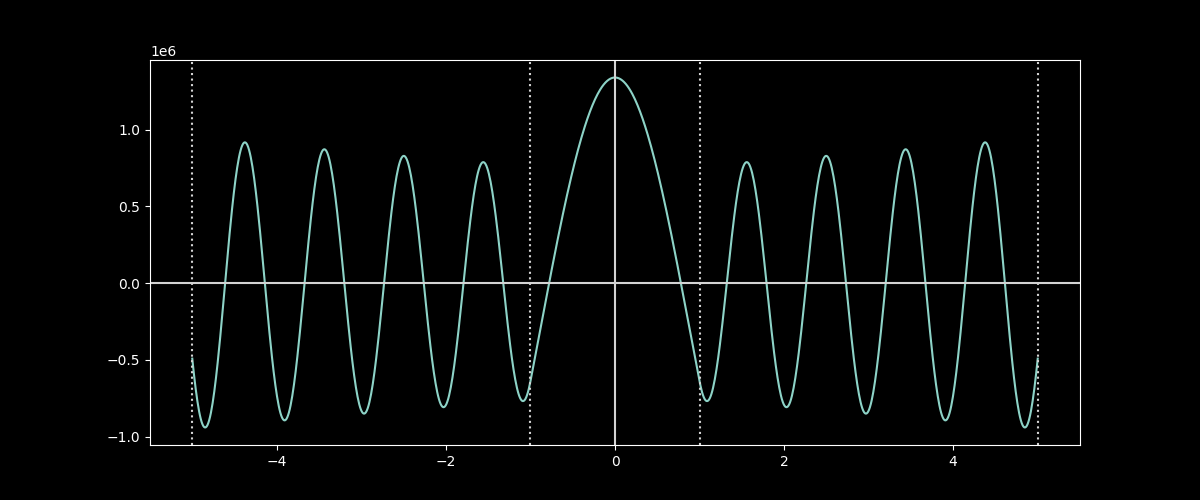

In [29]:
A.plot_field_1d(lambda x: -Fs3(x));


This is pretty big...  Need to double check implementation.  Another thing is how does even vs odd choice get made in this case? (Ie there are linearly independent leaky modes here, how do we choose later which one to pick at a pole?  Answer is that there is no choice, you form the contour integral around the pole with both mode classes, and result turns out to be even or odd (amazingly)).

In [32]:
Fs3_odd = A.fields(beta1, field_type='TE', mode_type='radiation', paper_method=False, sign='-1')


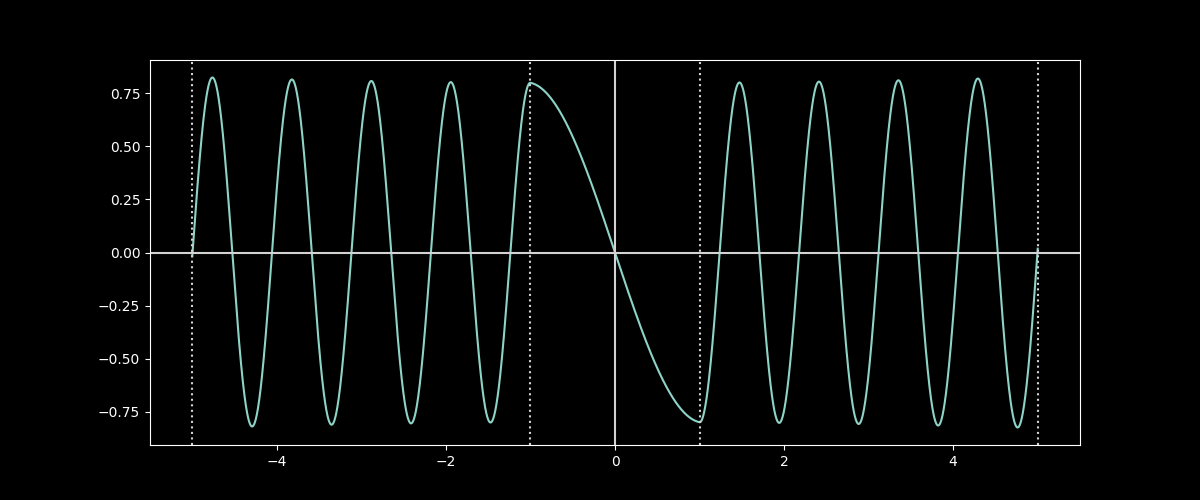

In [33]:
A.plot_field_1d(Fs3_odd, xs=np.linspace(-5,5,40000));


In [34]:
A.coefficients(beta1, mode_type='radiation', sign='1', paper_method=False, field_type='TE').T

array([[ 1.21484000e-07+1.82772000e-07j,  4.01435579e+05-6.03959675e+05j],
       [-6.70007579e+05-1.45672788e+06j, -6.70007579e+05-1.45672788e+06j],
       [ 4.01435579e+05-6.03959675e+05j,  1.21654000e-07+1.82830000e-07j]])

But if these truly are leaky modes, the should be the residues associated with poles of the radiation modes, and so I shouldn't be able to form a radiation mode at those values of Z. (Note that we later figure out this is a numerical artifact due to taking the square root of something close to machine zero). So something is off here.  Let's try in the Z plane, where there should be no differentiation between leaky and guided in eigval equation

## Working in Z plane

We don't need to refind root, we can just do the beta to Z transformation:

In [48]:
Z0 = A.Z_from_Beta(beta1)
Z0

array([6.68512884-0.05373814j])

Note that definition of n0 is max of outer refractive indices.  This affects plot of eigenequation in Z plane: tending to shift the eigenvalues away from zero.  The previous method of using n0=min(ns) kept eigenvalues close to zero.  However, the current method is what we want, since we integrate in the Z variable associated with the new definition of n0.

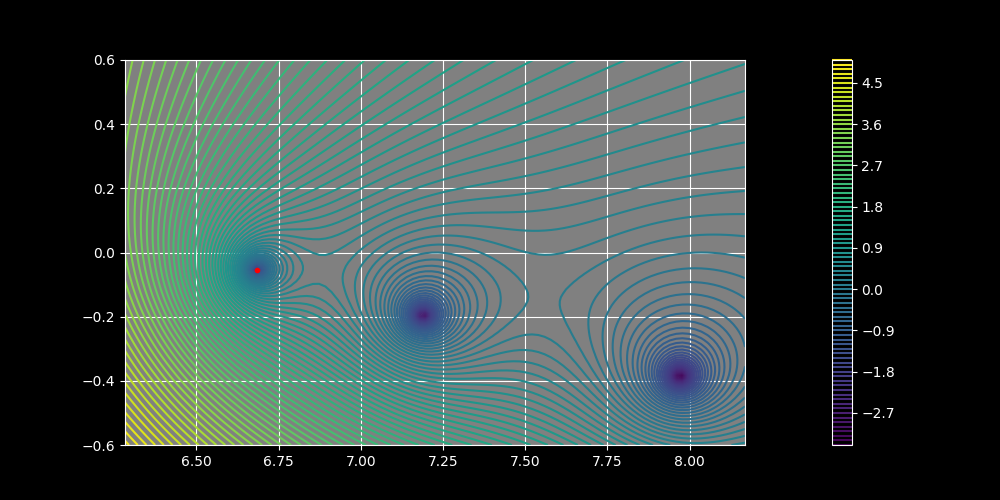

In [49]:
plotlogf(A.determinant_Z, A.K_low, 1.3*A.K_low, -.6, .6, 'TE', 'guided',
         iref=100, rref=100,levels=100, figsize=(10,5));
plt.plot(Z0.real, Z0.imag, '-o', markersize=3, color='r' );

## Plotting coefficients of radiation modes

At the leaky modes, we should have poles when we attempt to form radiation modes.  So the coefficients for radiation modes there should be infinite (or maybe zero?).  Here we plot the coefficients directly to see about this.  

First we check the coefficients at our leaky mode propagation constant.

In [50]:
inds = np.arange(Z0.ndim+1)
inds[-1], inds[-2] = inds[-2], inds[-1]
A.coefficients_Z(Z0, mode_type='radiation', sign='1', paper_method=True).transpose(inds)

array([[ 1.23239e-07+1.77325e-07j,  1.23239e-07-1.77325e-07j],
       [-6.00778e-07+1.10188e-07j, -3.79857e-07-2.47365e-07j],
       [-3.03437e-07-2.32666e-07j, -1.23239e-07-1.77325e-07j]])

Well, we're still able to form them.  Let's just plot the coefficients

In [51]:
def coeffs2d(Z):
    inds = np.arange(Z.ndim+2)
    inds[0], inds[1] = inds[1], inds[0]
    C = A.coefficients_Z(Z, mode_type='radiation', sign='1', paper_method=True).transpose(inds)
    return C[..., 0,0]

def coeffs(Z):
    return A.coefficients_Z(Z, mode_type='radiation', sign='1', paper_method=True).T[...,0,0]

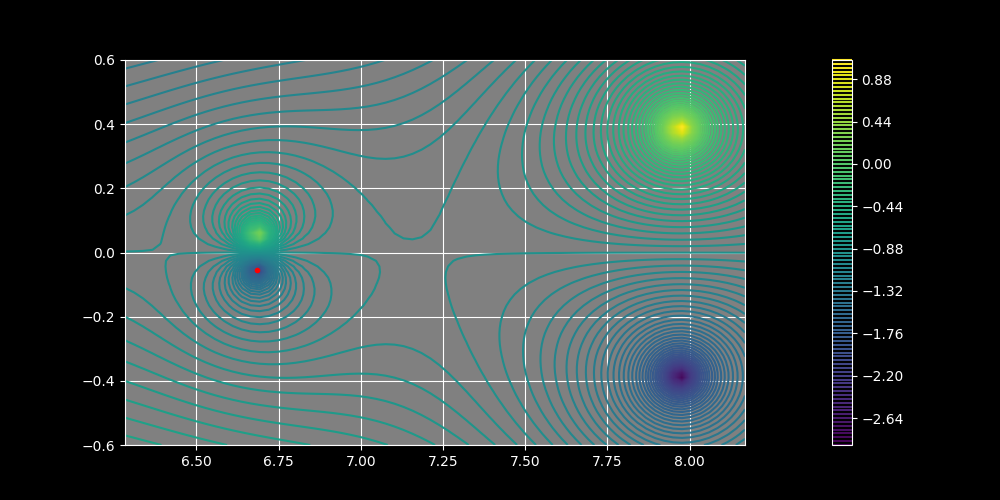

In [52]:
plotlogf(coeffs2d, A.K_low, 1.3*A.K_low, -.6, .6, 
         iref=70, rref=70, levels=100,
         figsize=(10,5), loop=False)
plt.plot(Z0.real, Z0.imag, '-o', markersize=3, color='r' );

Zoom in to see if leaky mode propagation constant is at min of coefficient norm plot:

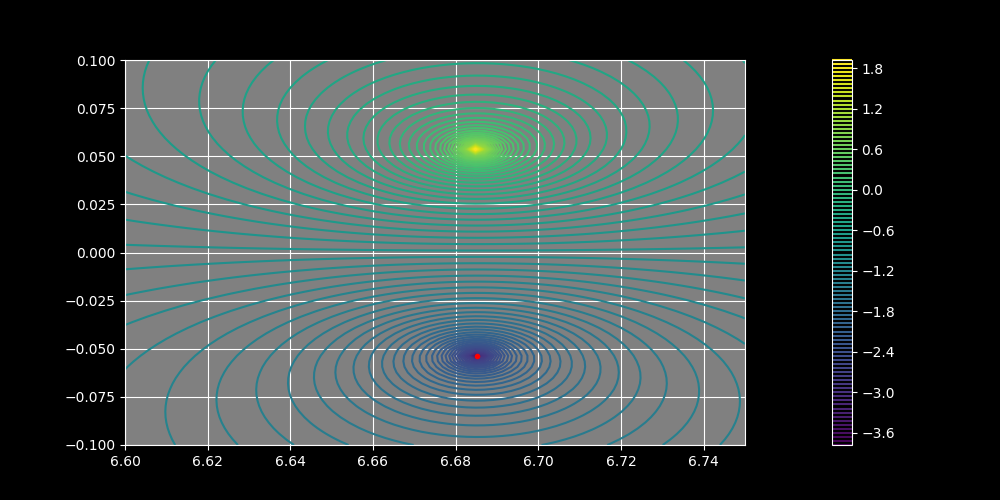

In [53]:
plotlogf(coeffs2d, 6.6, 6.75, -.1, .1,  
         iref=70, rref=70, levels=100,
         figsize=(10,5))
plt.plot(Z0.real, Z0.imag, '-o', markersize=3, color='r' );

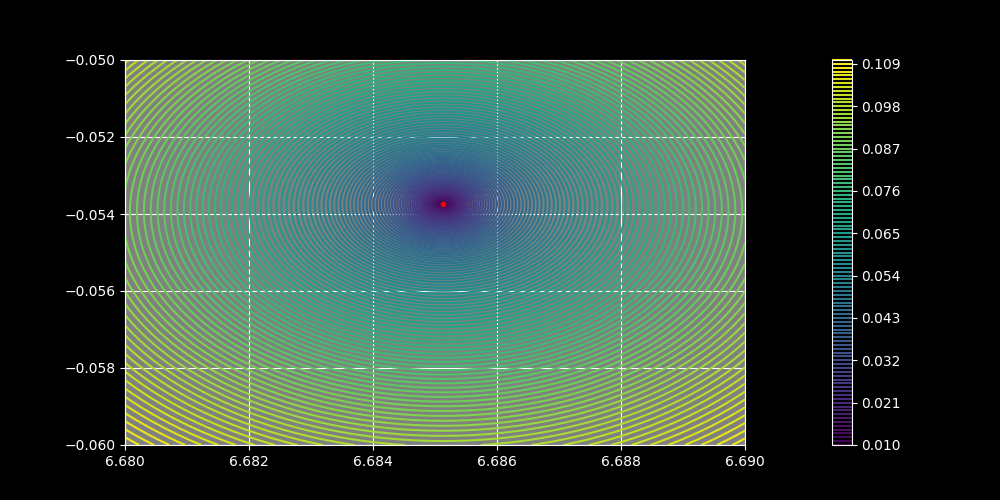

In [54]:
plotlogf(coeffs2d, 6.68, 6.69, -.05, -.06,   
         iref=70, rref=70, levels=100,
         figsize=(10,5), log_off=True)
plt.plot(Z0.real, Z0.imag, '-o', markersize=3, color='r');

Is this really a zero though?

In [55]:
np.abs(coeffs(Z0))

2.1594445291787425e-07

It's small, but not really a zero.  Similarly, is the conjugate a pole?

In [56]:
np.abs(coeffs(Z0.conj()))

737104.8808204432

It's big, but again doesn't really seem like big enough to be a pole.  Maybe the zeros are very near?

In [57]:
Z_pole = newton(coeffs, np.array(Z0), tol=1e-6)
print(Z_pole, abs(coeffs(Z_pole)))


[6.68512927-0.0537381j] 0.0008202171465429339


Can't take tolerance above much lower and have it converge.  So something seems off, we seem to be able to form radiation modes with the zeros of the eigenequation, when I thought these were poles (in the sense that the coefficients of the radiation modes blew up at those points.  Next we do some algebra and see if we can see the issue.

# Poles of radiation modes in this case

After some algebra, it looks like, for the paper version of definining radiation mode coefficients, a pole will occur when 
$(-M[1,0] \pm 1 ) / M[1,1] = 0$

In [58]:
def algebraic_coeffs(Z, sign='1'):
    M = A.transmission_matrix_Z(Z, field_type='TE')
    detM = (M[..., 0, 0] * M[..., 1, 1] - M[..., 0, 1] * M[..., 1, 0])
    return (-M[..., 1, 0] + int(sign))/M[..., 1, 1]


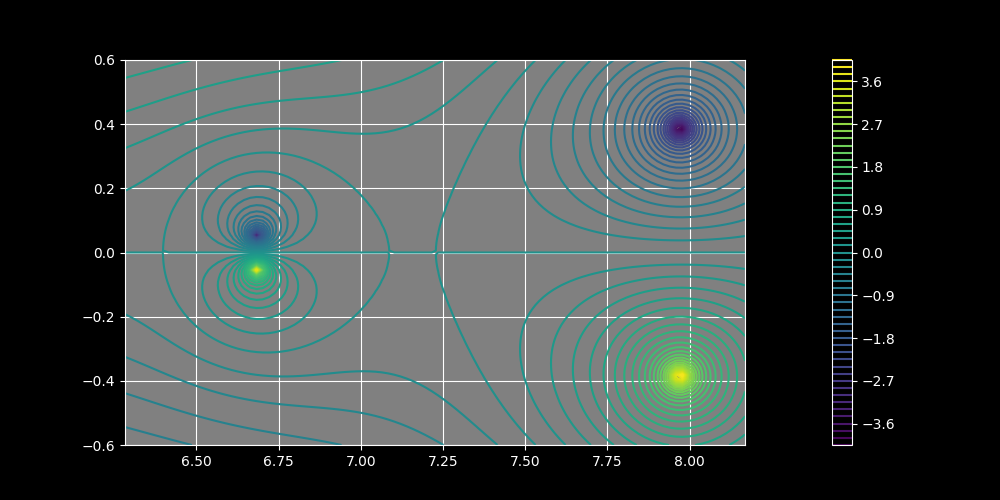

In [62]:
# plt.close('all')
plotlogf(algebraic_coeffs, A.K_low, 1.3*A.K_low, -.6, .6, 
         iref=100, rref=100, levels=70,
         figsize=(10,5))

Now the zeros of the eigenequation appear to be zeros of this function

In [63]:
np.abs(algebraic_coeffs(Z0.conj()))

array([2.90316773e-13])

They are, and the only difference between this and the true coefficients is a reciprocal square root.  That is what halves the error that should otherwise be below machine precision:

In [64]:
np.abs((algebraic_coeffs(Z0.conj()))**.5)

array([5.38810517e-07])

Okay, so these are in fact poles (/zeros), but the numerics is hiding it.  The normed squared would reveal it.

## Poles vs zeros

The above analysis can tell us when we have a zero or pole.  Looking at just the numerator in the algebraic form:

In [65]:
def numerator(Z, sign='1'):
    M = A.transmission_matrix_Z(Z, field_type='TE')
    detM = (M[..., 0, 0] * M[..., 1, 1] - M[..., 0, 1] * M[..., 1, 0])
    return -M[..., 1, 0] + int(sign)

def M11(Z):
    M = A.transmission_matrix_Z(Z, field_type='TE')
    return M[...,1,1]

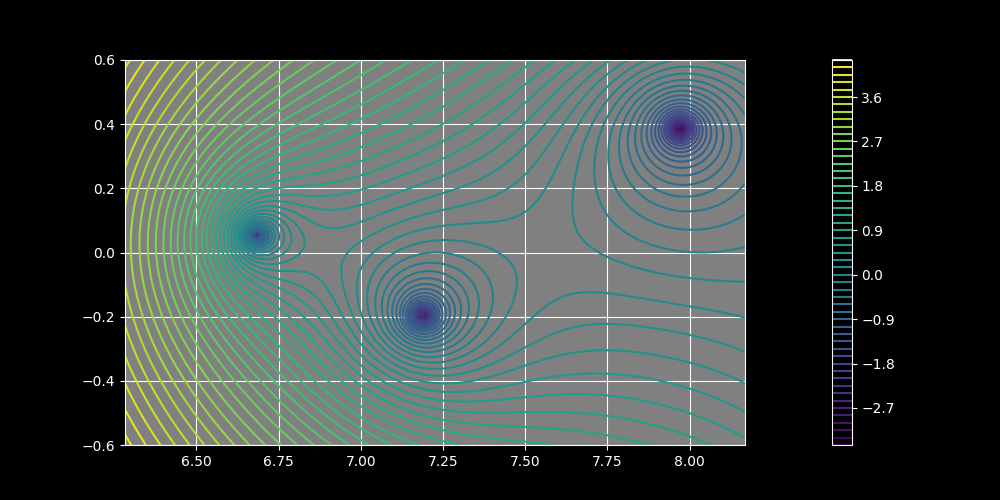

In [66]:
plotlogf(numerator, A.K_low, 1.3*A.K_low, -.6, .6, 
         iref=100, rref=100, levels=70,
         figsize=(10,5))

Now looking at the denominator:

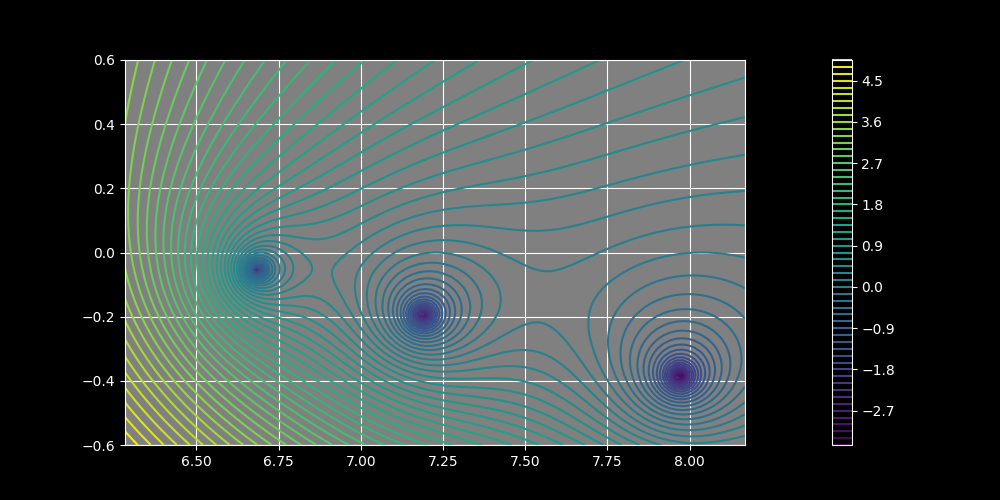

In [67]:
plotlogf(M11, A.K_low, 1.3*A.K_low, -.6, .6, 
         iref=100, rref=100, levels=70,
         figsize=(10,5))

And the ratio:

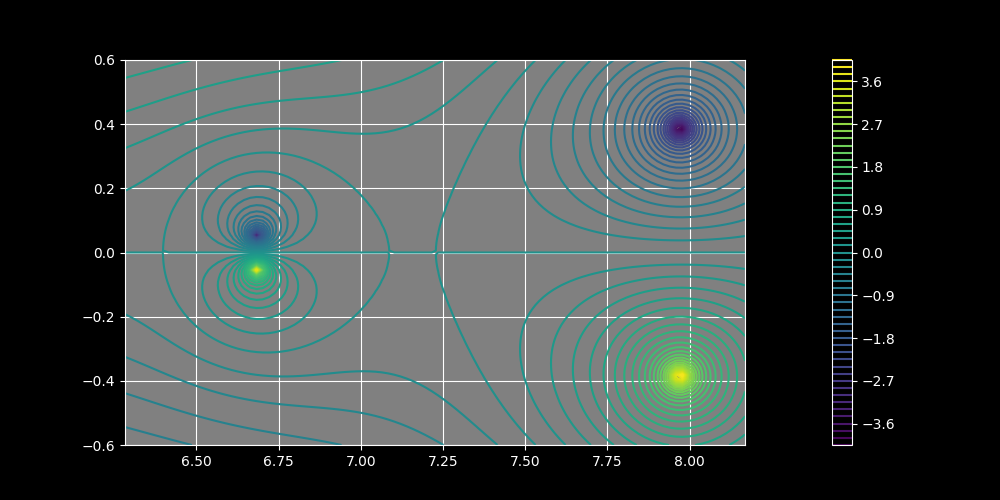

In [69]:
plotlogf(algebraic_coeffs, A.K_low, 1.3*A.K_low, -.6, .6,
         iref=100, rref=100, levels=70,
         figsize=(10,5))

The roots in the numerator and denominator are shared for the odd cases, but are conjugate for the even cases (assuming we pass sign=1 to the coeff function and numerator).  This gives a removable 
discontinuity for the odd modes, but a pole/root conjugate set for the even modes.

## Conclusions

So we've largely figured out the issues:

- There's a numerics issue with taking the square root when forming coefficients: this takes poles/roots to something with double the size, so they appear to not quite be poles/roots anymore.  But they really are poles and roots.

- There are some removable discontinuities.  They later have poles or roots over them when we look at the coefficients with the alternate parity.  Still could look at this further to get better clarity.

Below is a surface plot of the coefficients, just for fun:

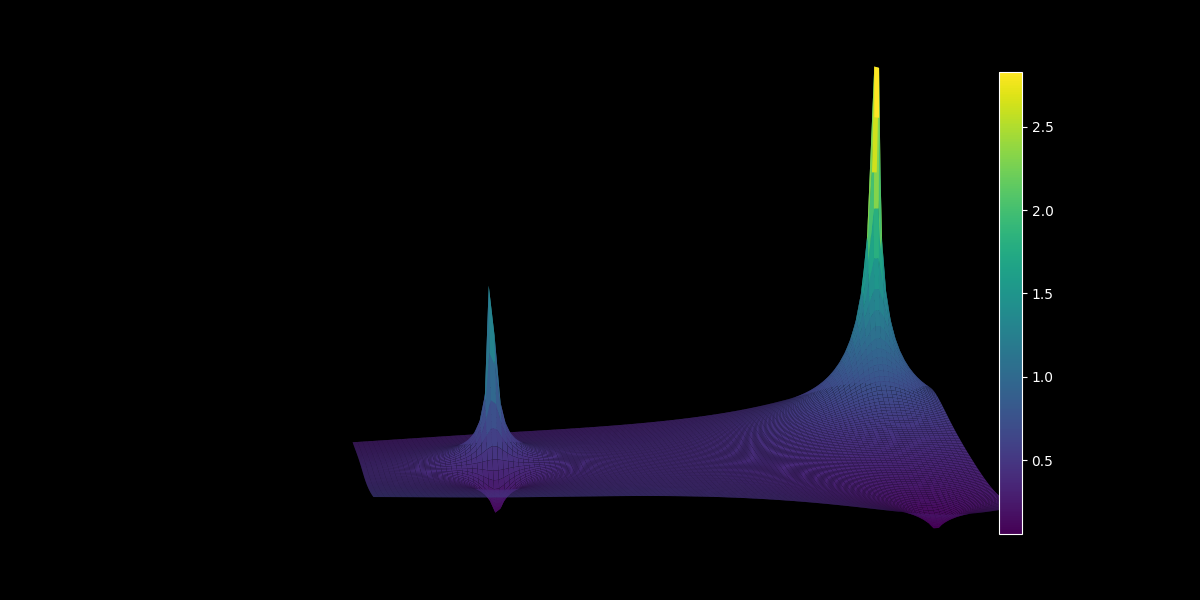

In [70]:
plotlogf(coeffs2d, A.K_low, 1.3*A.K_low, -.6, .6,
         iref=120, rref=120, levels=70, three_D=True,
         rstride=1, cstride=1, azim=-100, elev=10, colorbar=True,
         zoom=2, log_off=True)

# Returing to forming leaky modes

We now re-examine the standard method of forming leaky modes we started with.  Get zero in Z plane

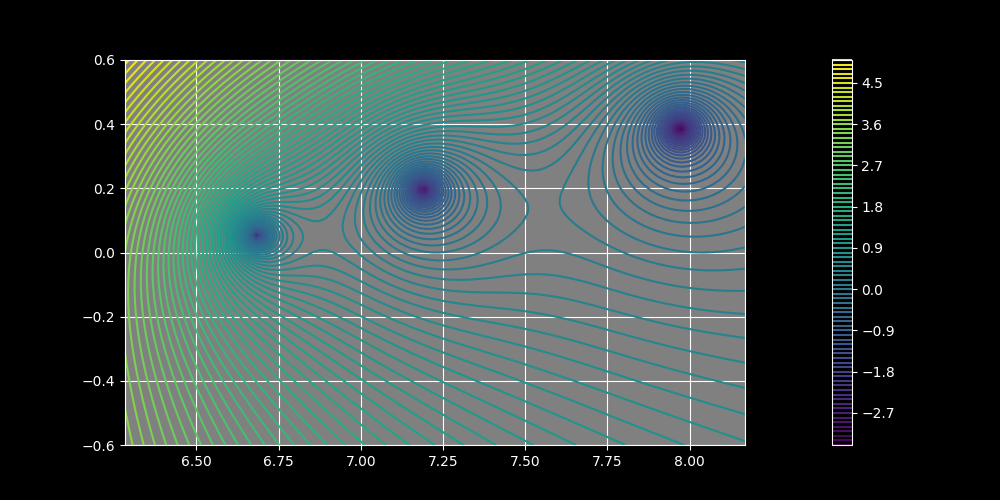

In [71]:
plotlogf(A.determinant_Z, A.K_low, 1.3*A.K_low, -.6, .6, 'TE', 'leaky',
         iref=100, rref=100,levels=100, figsize=(10,5));


Get Z propagation constant:

In [72]:
Z0 = newton(A.determinant_Z, np.array([1.01*A.K_low]), args=('TE', mode_type))
print(Z0, abs(A.determinant_Z(Z0, 'TE', mode_type)))
plt.plot(Z0.real, Z0.imag, '-o', markersize=3, color='r' );

[6.68512884+0.05373814j] [2.98891431e-12]


Examine transmission matrix:

In [74]:
M = A.transmission_matrix_Z(Z0)[0] 
M

array([[ 2.81622150e-12+1.00125185e-12j, -1.00000000e+00-2.74302803e-12j],
       [ 1.00000000e+00+2.75440781e-12j, -1.33806441e+00-1.47624142e+00j]])

We can see by inspection for this transmission matrix M that $(-M[1,0] + 1 ) / M[1,1] = 0$:

In [75]:
(-M[1,0] + 1 ) / M[1,1] 

(1.4101979512599471e-12+5.026777404494829e-13j)

Therefore the coefficients of the radiation modes  should blow up

In [76]:
A.coefficients_Z(Z0,  mode_type='radiation').T

array([[ 321587.73574373 -55462.19708444j,
         321587.73574373 +55462.19708444j],
       [ 617660.13237525+159553.7387185j ,
         966145.91726892-371461.6822123j ],
       [-321587.73574298 -55462.19708522j,
         -26841.77416113-604415.3234003j ]])

So we can't form a radiation mode there.  But we can form a leaky mode there:

In [77]:
A.coefficients_Z(Z0,  mode_type='leaky').T

array([[1.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j],
       [1.16147428e+00+1.88135852e+00j, 1.16147428e+00+1.88135852e+00j],
       [3.00000000e-12+1.00000000e-12j, 1.00000000e+00+3.00000000e-12j]])

It not just remains to see how the residues of integrating radiation modes give rise to leaky modes.

## Components of coefficients

Here we briefly look at some of the parts that go into building the coefficients, mostly the factor b and detM, which we see are unstable for this waveguide.  We note that this instability is wavelength dependent.  It gets worse for shorter wavelengths, so we reform our class here with a shorter wavelength.

In [78]:
B = SlabExact(scale=1e-6, ts=[4e-6, 2e-6,4e-6],
              ns=[1.44, 1, 1.44], xrefs=[400, 200, 400],
              symmetric=True, wl=.55e-6)

In [79]:
def detM(Z):
    M = B.transmission_matrix_Z(Z, field_type='TE')
    detM = M[..., 0, 0] * M[..., 1, 1] - M[..., 0, 1] * M[..., 1, 0]
    return detM

def b(Z, sign='1'):
    M = B.transmission_matrix_Z(Z, field_type='TE')
    detM = (M[..., 0, 0] * M[..., 1, 1]
            - M[..., 0, 1] * M[..., 1, 0])
    frac = (-M[..., 1, 0] * detM) / \
        (M[..., 0, 1])
    
    b0 = np.sqrt(frac, dtype=complex)
    b = int(sign) * b0
    return b


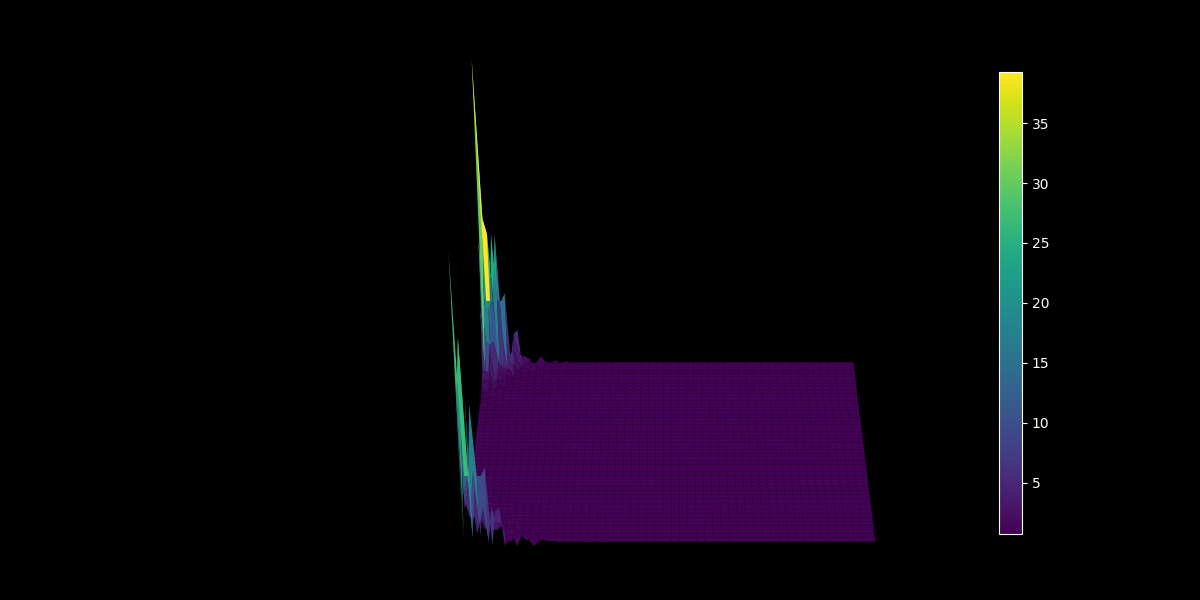

In [80]:
plotlogf(detM, 8, 20,  -5, 5,
         iref=100, rref=100, levels=70,
         log_off=True, three_D=True, elev=30)

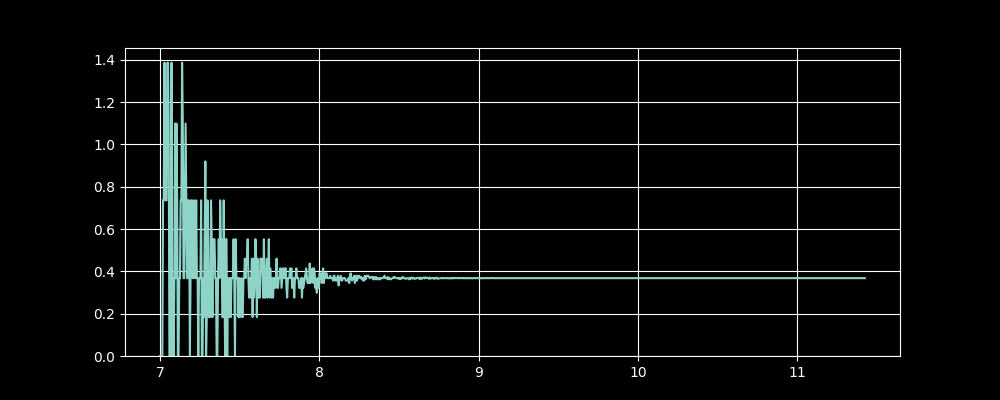

In [81]:
plotlogf_real(detM, 7, B.K_low)

Not yet sure why this is unstable.  Need to look into it.

# Why is determinant unstable at low Z?

Let's try some low Zs and see what the pieces look like:

In [82]:
Zt = .1
B.transmission_matrix_Z(Zt, field_type='TE')


array([[-1.02921380e+11-5.55798167e+11j, -7.62939453e-05-5.65247214e+11j],
       [-7.62939453e-05+5.65247214e+11j, -1.02921380e+11+5.55798167e+11j]])

In [83]:
B.transfer_matrix_Z(Zt, A.Rhos[1], A.ns[0], A.ns[1])


array([[3.59670121e-06-3.91592331e-07j, 3.59670121e-06+3.91592331e-07j],
       [6.88153199e+04-6.31782428e+03j, 6.88153199e+04+6.31782428e+03j]])

In [84]:
B.transfer_matrix_Z(Zt, A.Rhos[2], A.ns[1], A.ns[2])

array([[ 4.63507867e-05+4.25723175e-04j, -7.47808632e+05-8.14531838e+06j],
       [ 4.63507867e-05-4.25723175e-04j, -7.47808632e+05+8.14531838e+06j]])

So yeah, transfer matrices are not great, and it all works.  Looking at individiual determinants:

In [85]:
det1 = np.linalg.det(B.transfer_matrix_Z(Zt, A.Rhos[1], A.ns[0], A.ns[1]))
det2 = np.linalg.det(B.transfer_matrix_Z(Zt, A.Rhos[2], A.ns[1], A.ns[2]))
det1, det2, det1*det2

((-2.5325093783554876e-17-0.008448450587165968j),
 (-1.1498500660259917e-14+118.36489894597938j),
 (1-2.9004576518332223e-15j))

Numerical determinant is way off from this:

In [86]:
np.linalg.det(B.transmission_matrix_Z(Zt, field_type='TE'))


(-70987367.15563375-4397968.89110636j)

More manual version, but still kind of numerical, also way off:

In [87]:
detM(Zt)

(-67108864+0j)

They're all quite different.  True determinant is 1, as seen a few cells up.  We should hard code determinant into the class using theory to avoid issues with this.  We have now done this:

In [90]:
B.transmission_determinant_Z(Zt), 

(1+0j)

In [93]:
Fr = B.fields_Z(.01*A.Z_hyperbolic, mode_type='radiation', sign='-1')

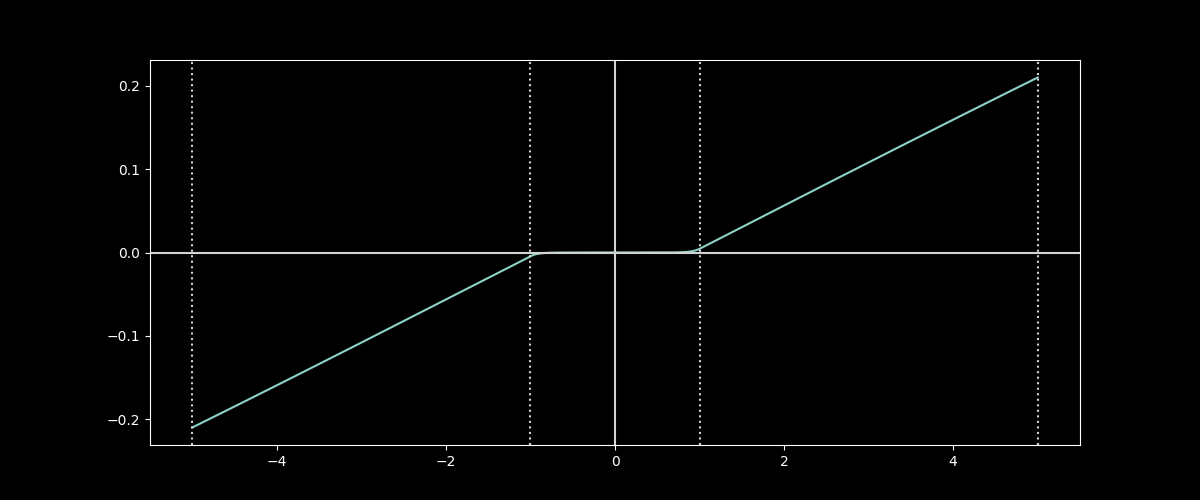

In [94]:
A.plot_field_1d(Fr);

In [103]:
B.wavelength=.4e-6

In [104]:
B.wavelength

4e-07

In [105]:
Fr = B.fields_Z(.01*A.Z_hyperbolic, mode_type='radiation', sign='-1')

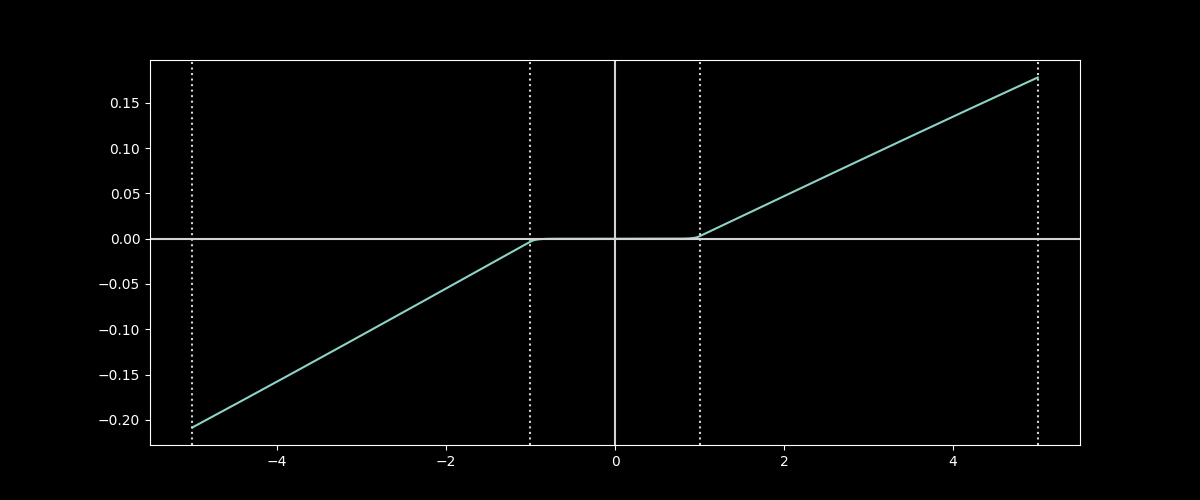

In [106]:
A.plot_field_1d(Fr);

It does seem to help this, so that's nice for propagation at short wavelengths.